In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import glob
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data Processing

In [2]:
#Define the shape of the images and the batch size
image_size = (500, 500)
batch_size = 32

In [3]:
#Set the paths for the train and validation directories
train_dir = pathlib.Path('Data/train')
val_dir = pathlib.Path('Data/valid')

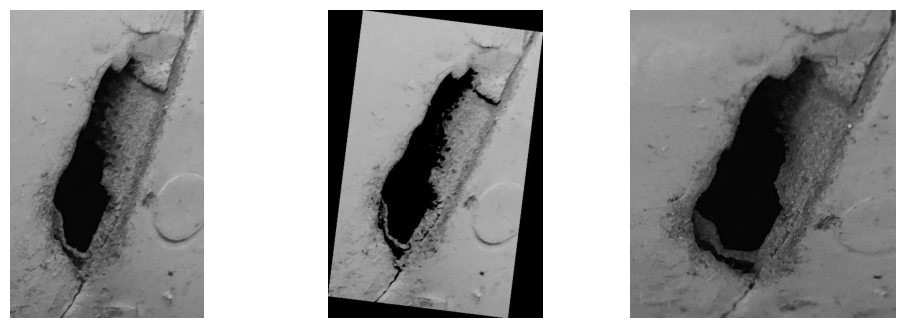

In [4]:
#Printing a few examples from the training set
cracks = list(train_dir.glob('crack/*'))

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i in range(3):
    image = Image.open(str(cracks[i]))
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [5]:
#Create train and validation datasets
train_ds = image_dataset_from_directory(
    train_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
    shuffle=True
)

Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


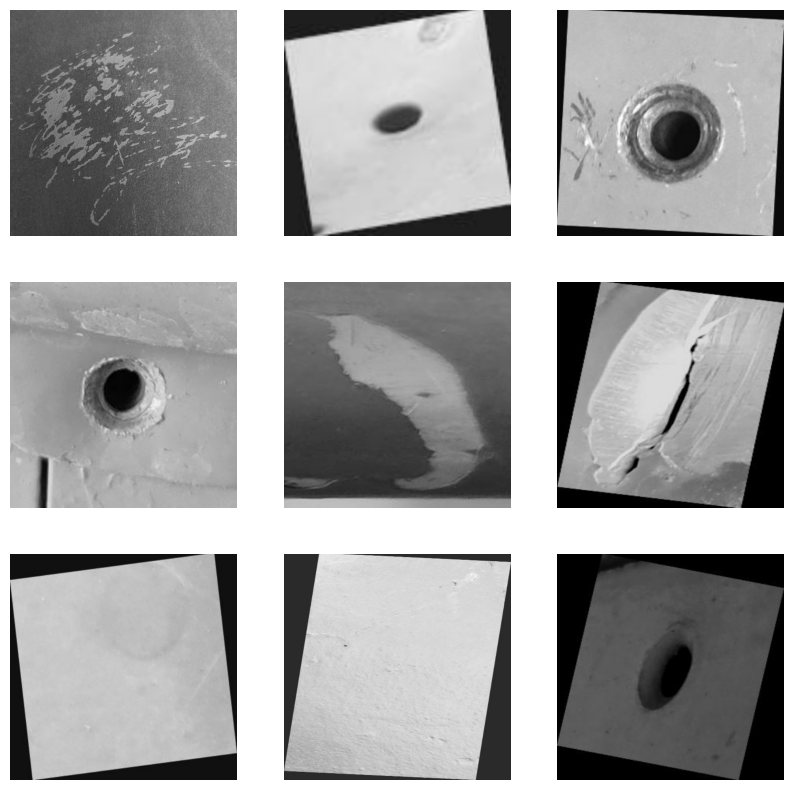

In [ ]:
#Visualizing images from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#Data Augmentation 